### This is notebook of development of a top tagger using scikit-learn, tensorflow and pandas

In [1]:
from common import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.covariance import EmpiricalCovariance

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

from baseTagger import *

%matplotlib inline

#### The get_csv() function to read data from csv file. The original csv file is produced from ROOT file using the [convert_ROOT_to_CSV.py](convert_ROOT_to_CSV.py) code. The data includes various kinematic variables from both the $t\bar{t}$ (ttbar) sample and $Z(\rightarrow\nu\nu$) (zinv) sample. The ttbar sample contains the top quark signal while the zinv sample contains pure background. We select three AK4 jets for a combination where we introduce the major kinematic variables in the top quark rest-frame.

In [2]:
def get_csv(orifilename, outfilename, forceRedo = False):
    if not os.path.isfile(outfilename) or forceRedo:
        if not os.path.isfile(orifilename):
            print('orifilename : {} does not exist!'.format(orifilename))
            sys.exit(1)        
        df_ori = pd.read_csv(orifilename, compression='gzip')
        df = df_ori[(df_ori['cand_dRMax']<1.5) & (df_ori['cand_m']>100) & (df_ori['cand_m']<250)]
        to_drop = [x for x in df_ori.columns if 'Unnamed' in x]
        df = df.drop(to_drop, axis=1)
        df.to_csv(outfilename)
    else:
        df = pd.read_csv(outfilename)
        to_drop = [x for x in df.columns if 'Unnamed' in x]
        df = df.drop(to_drop, axis=1)
    return df

#### The samples are split into two. One is used for training, the other is used for validation.

In [3]:
# Load the training sample
df = get_csv('training.csv', 'dRMax_LE_1p5_m_in_100_250_training.csv')
# Load the validation sample
val_df = get_csv('validation.csv', 'dRMax_LE_1p5_m_in_100_250_validation.csv')
val_npInputWgt = np.array(val_df.ix[:, 'sampleWgt'])
val_npInputList = np.array(val_df.ix[:, :'j3_QGL'])
val_npInputAnswers = np.array(val_df.ix[:, 'answer'])
val_npInputList_ttbar = np.array(val_df[val_df['procTypes']=='ttbar'].ix[:, :'j3_QGL'])
val_npInputAnswers_ttbar = np.array(val_df[val_df['procTypes']=='ttbar'].ix[:, 'answer'])
val_npInputList_zinv = np.array(val_df[val_df['procTypes']=='zinv'].ix[:, :'j3_QGL'])
val_npInputAnswers_zinv = np.array(val_df[val_df['procTypes']=='zinv'].ix[:, 'answer'])
val_slimNpData0_ttbar = val_npInputList_ttbar[val_npInputAnswers_ttbar==0]
val_slimNpData1_ttbar = val_npInputList_ttbar[val_npInputAnswers_ttbar==1]
val_slimNpData_zinv = val_npInputList_zinv[val_npInputAnswers_zinv==0]

#### Plots of the major kinematic variables and their correlations
The 1D histograms clearly show the difference in shapes between sginal and background

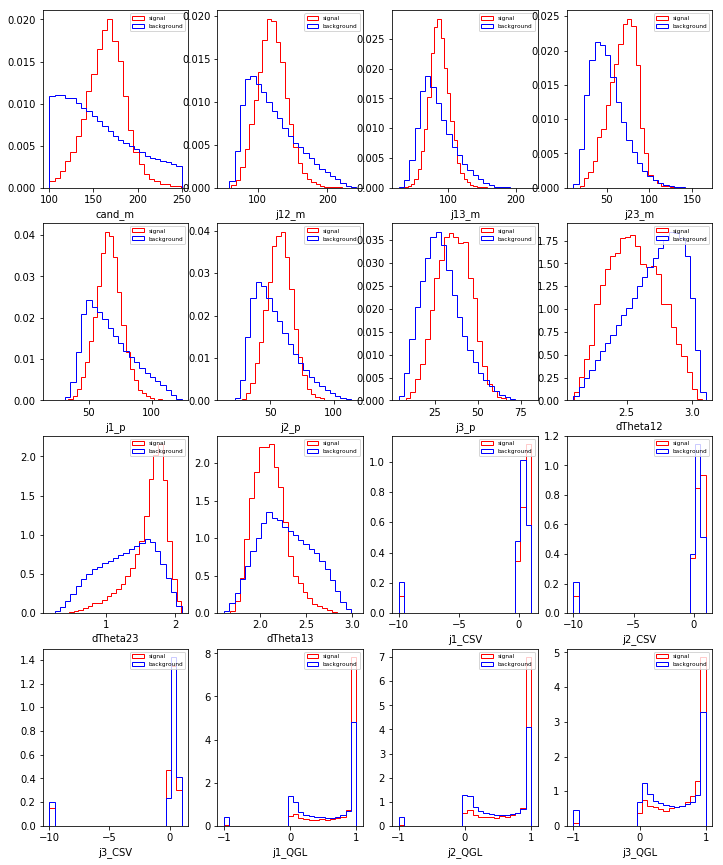

In [4]:
plt.rc('figure', figsize=(12, 15))
nfig_x = 4
nfig_y = 4
figs, axes = plt.subplots(nfig_y, nfig_x)
for iy in range(nfig_y):
    for ix in range(nfig_x):
        _=axes[iy, ix].hist(df[df['answer']==1].ix[:, ix+iy*nfig_x], bins=25, normed=True, color='red', histtype='step', label='signal')
        _=axes[iy, ix].hist(df[df['answer']==0].ix[:, ix+iy*nfig_x], bins=25, normed=True, color='blue', histtype='step', label='background')
        _=axes[iy, ix].set_xlabel(df.columns[ix+iy*nfig_x])
        _=axes[iy, ix].legend(loc='best', fontsize='xx-small')

The scatter plots are useful to see the correlations. Since there are correlations between variables, one expects neural network does better than decision trees.

In [5]:
from scipy.stats import gaussian_kde
from sklearn.neighbors.kde import KernelDensity
plt.rc('figure', figsize=(15, 15))

def plot_scatter(df_input, nVars, nBins):
    # See http://matplotlib.org/users/colormaps.html
    # also, http://matplotlib.org/api/pyplot_summary.html?highlight=colormaps#matplotlib.pyplot.colormaps
    cm = plt.cm.get_cmap('rainbow')
    figs, axes = plt.subplots(nVars, nVars)
#    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0, wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for iy in range(nVars):
        for ix in range(nVars):
            x_col = df_input.ix[:, ix]
            y_col = df_input.ix[:, iy]
            if ix != iy:
                xy_col = list(zip(x_col, y_col))
                bandwidth = max((np.amax(x_col)-np.amin(x_col))/nBins, (np.amax(y_col)-np.amin(y_col))/nBins)
                kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(xy_col)
                z = np.exp(kde.score_samples(xy_col)) 
                # See http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
                # s: marker size   lw: line width
                sc =axes[iy, ix].scatter(x_col, y_col, c=z, cmap=cm, marker='.', s=2, label='(%s, %s)'%(df.columns[ix], df.columns[iy]))
#                _=axes[iy, ix].legend(loc='best', fontsize='small')
#                _=figs.colorbar(sc, ax=axes[iy, ix])
            else:
                _=axes[iy, ix].hist(x_col, bins=nBins)
            # first make all axes invisible for all subplots
            _=axes[iy, ix].get_xaxis().set_visible(False)
            _=axes[iy, ix].get_yaxis().set_visible(False)            
            if ix ==0:
                _=axes[iy, ix].set_ylabel(df.columns[iy])
                _=axes[iy, ix].get_yaxis().set_visible(True)
            if iy == nVars-1:
                _=axes[iy, ix].set_xlabel(df.columns[ix])
                _=axes[iy, ix].get_xaxis().set_visible(True)
            if ix == nVars-1:
                _=axes[iy, ix].yaxis.set_label_position('right')
                _=axes[iy, ix].yaxis.tick_right()
                _=axes[iy, ix].set_ylabel(df.columns[iy])
                _=axes[iy, ix].get_yaxis().set_visible(True)
            if iy == 0:
                _=axes[iy, ix].xaxis.set_label_position('top')
                _=axes[iy, ix].xaxis.tick_top()
                _=axes[iy, ix].set_xlabel(df.columns[ix])
                _=axes[iy, ix].get_xaxis().set_visible(True)
#    figs.tight_layout()
    plt.show()

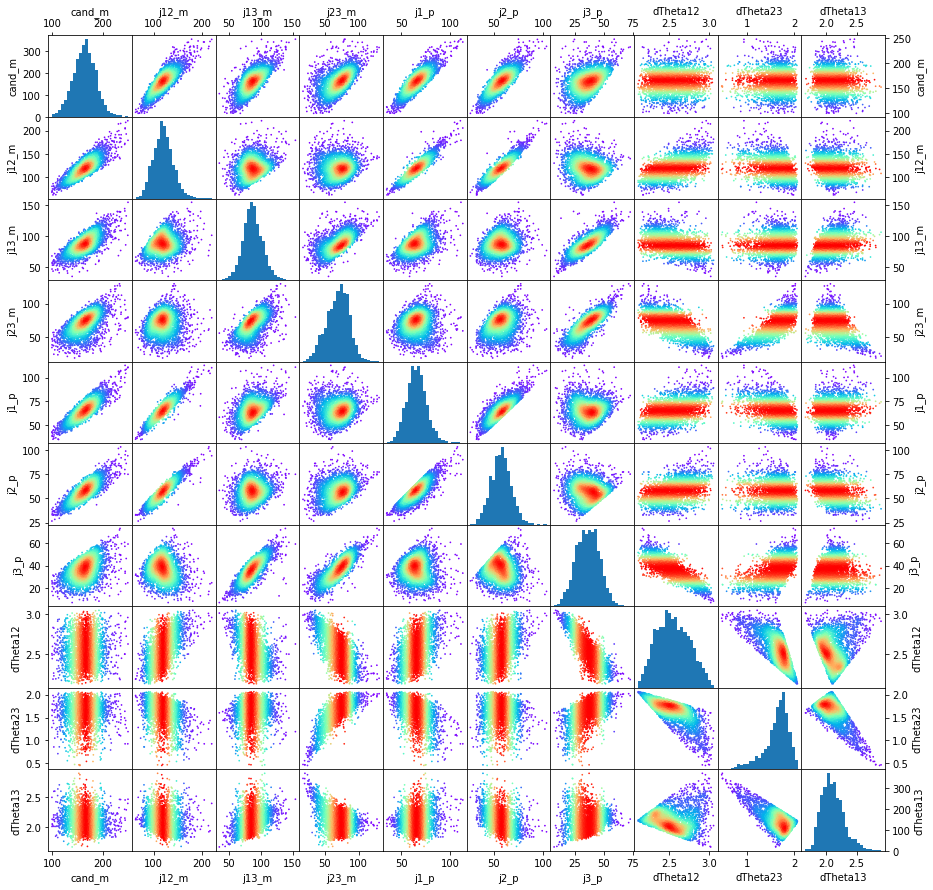

CPU times: user 1min 7s, sys: 334 ms, total: 1min 7s
Wall time: 1min 7s


In [6]:
#len_true_answer = len(df[df['answer']==1])
nSamples_for_scatterPlots = 3000
%time plot_scatter(df[df['answer']==1].sample(nSamples_for_scatterPlots), 10, 25)

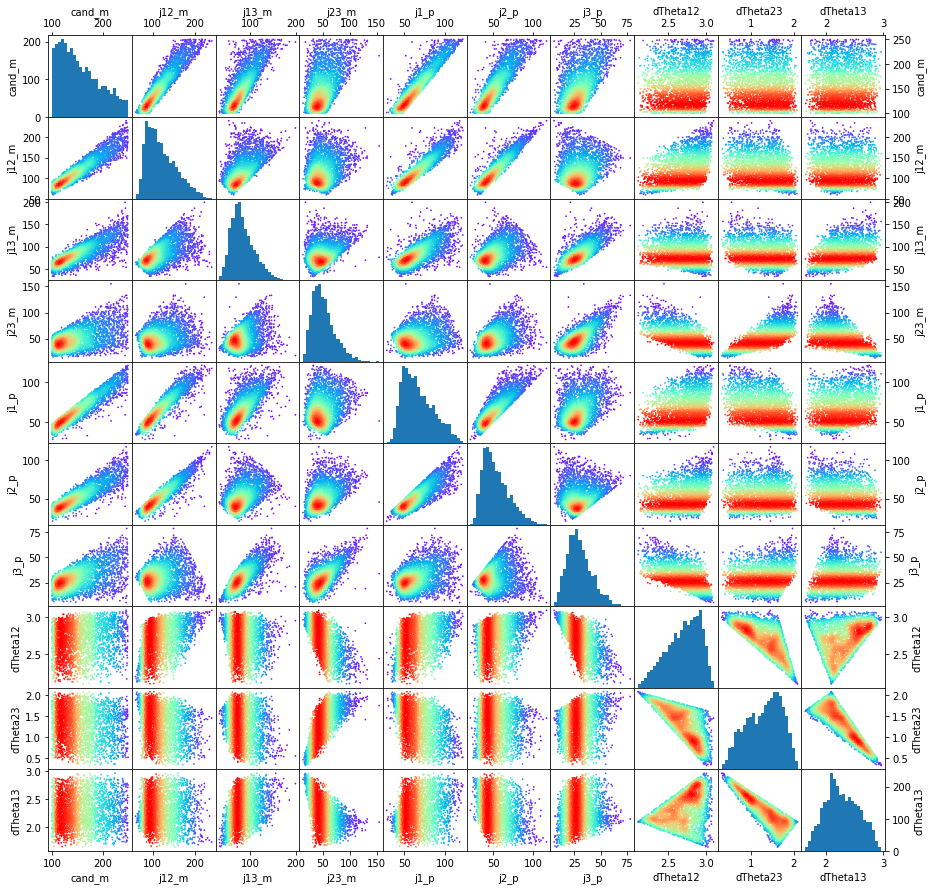

CPU times: user 1min 6s, sys: 248 ms, total: 1min 6s
Wall time: 1min 6s


In [7]:
#_=pd.scatter_matrix(df[df['answer']==0].ix[:, :'dTheta13'], diagonal='kde', c='k', alpha=0.3)
%time plot_scatter(df[df['answer']==0].sample(nSamples_for_scatterPlots), 10, 25)

#### Equalize the weighted number of events for signal and background

In [8]:
nSig_wt = df[df['answer']==1].weight.sum()
nBkg_wt = df[df['answer']==0].weight.sum()
weight = nSig_wt/nBkg_wt
df.loc[df['answer']==0, 'weight'] *= weight

#### Randomize the data before feeding into the classifier

In [9]:
df_shuffled = df.reindex(np.random.permutation(df.index))
npyInputData = np.array(df_shuffled.ix[:, :'j3_QGL'])
npyInputAnswer = np.array(df_shuffled.ix[:, 'answer'])
npyInputWgts = np.array(df_shuffled.ix[:, 'weight'])
list_procType = (df_shuffled.ix[:, 'procTypes']).tolist()

#### Start the Random Forest classifier using scikit-learn package

In [10]:
#clf = RandomForestClassifier(n_estimators=100, max_depth=14, n_jobs=4)
clf = RandomForestClassifier(n_estimators=100, max_depth=18, n_jobs=4)
%time clf = clf.fit(npyInputData, npyInputAnswer, npyInputWgts)

val_output = clf.predict_proba(val_npInputList)[:,1]
val_df['disc'] = val_output

CPU times: user 2min 27s, sys: 702 ms, total: 2min 28s
Wall time: 37.7 s


#### Start the MLP classifier using scikit-learn package

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

scaler = StandardScaler()

_=scaler.fit(val_npInputList)
scaled_val_npInputList = scaler.transform(val_npInputList)

sel_sig_npyInputData = npyInputData[npyInputAnswer==1]
sel_bkg_npyInputData = npyInputData[npyInputAnswer==0]

sel_bkg_npyInputData_ttbar = np.array(df_shuffled[(df_shuffled['answer']==0) & (df_shuffled['procTypes']=='ttbar')].ix[:, :'j3_QGL'])
sel_bkg_npyInputData_zinv = np.array(df_shuffled[(df_shuffled['answer']==0) & (df_shuffled['procTypes']=='zinv')].ix[:, :'j3_QGL'])

sel_bkg_npyInputData = sel_bkg_npyInputData[np.random.permutation(sel_bkg_npyInputData.shape[0])][:int(sel_sig_npyInputData.shape[0]*3)]
sel_npyInputData = np.concatenate((sel_sig_npyInputData, sel_bkg_npyInputData))
sel_npyInputAnswer = np.concatenate((np.ones(sel_sig_npyInputData.shape[0]), np.zeros(sel_bkg_npyInputData.shape[0])))

perms = np.random.permutation(sel_npyInputData.shape[0])
sel_npyInputData = sel_npyInputData[perms]
sel_npyInputAnswer = sel_npyInputAnswer[perms]

_=scaler.fit(sel_npyInputData)
scaled_npyInputData = scaler.transform(sel_npyInputData)

clf_mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(8, 8), alpha=1e-5, random_state=1, learning_rate='adaptive', max_iter=1000)
%time clf_mlp.fit(scaled_npyInputData, sel_npyInputAnswer)
clf_mlp.loss_
clf_mlp.score(scaled_npyInputData, sel_npyInputAnswer)
#clf_mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(8, 8), max_iter=1, warm_start=True, alpha=1e-5, random_state=1, learning_rate='adaptive')
#maxIter_mlp = 100
#trn_mlp_loss = []
#val_mlp_loss = []
#trn_mlp_loss_alt = []
#for i in range(maxIter_mlp):
#    _=clf_mlp.fit(scaled_npyInputData, sel_npyInputAnswer)
#    trn_mlp_loss.append(clf_mlp.loss_)
#    trn_mlp_pred_proba_step = clf_mlp.predict_proba(scaled_npyInputData)[:, 1]
#    trn_mlp_loss_alt.append(log_loss(sel_npyInputAnswer, trn_mlp_pred_proba_step))
#    val_mlp_pred_proba_step = clf_mlp.predict_proba(scaled_val_npInputList)[:, 1]
#    val_mlp_loss.append(log_loss(val_npInputAnswers, val_mlp_pred_proba_step))  
val_mlp_output = clf_mlp.predict_proba(scaled_val_npInputList)[:, 1]

CPU times: user 10.7 s, sys: 179 ms, total: 10.8 s
Wall time: 10.9 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 8), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

0.33148576678979275

0.85302467787726577

#### My own MLP building using tensorflow. Here I try the MLP with three hidden layers.

In [12]:
import tensorflow as tf

tf_inputs = scaled_npyInputData
tf_answers = sel_npyInputAnswer.astype(int)
tf_max_class_order = np.max(tf_answers)
tf_one_hot_answers = np.eye(tf_max_class_order+1)[tf_answers]

tf_val_inputs = scaled_val_npInputList
tf_val_answers = val_npInputAnswers.astype(int)
tf_val_one_hot_answers = np.eye(tf_max_class_order+1)[tf_val_answers]

n_nodes_hl1 = 10
n_nodes_hl2 = 10
n_nodes_hl3 = 8

tf_n_inputs = tf_inputs.shape[1]
tf_n_classes = tf_one_hot_answers.shape[1]

tf_batch_size = 200
tf_n_epochs = 1000

beta = 1e-5
#learning_rate = 1e-3
learning_rate = 5e-3

tf_x = tf.placeholder('float', [None, tf_n_inputs])
tf_y = tf.placeholder('float')

def neural_network_model(data):
    hidden_1_layer = {'weights': tf.Variable(tf.random_normal([tf_n_inputs, n_nodes_hl1], seed=1)), 
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1], seed=2))}
    hidden_2_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2], seed=3)), 
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2], seed=4))}    
    hidden_3_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3], seed=5)), 
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3], seed=6))}
    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, tf_n_classes], seed=7)), 
                    'biases':tf.Variable(tf.random_normal([tf_n_classes], seed=8))}
    
    nn_layers = [hidden_1_layer, hidden_2_layer, hidden_3_layer, output_layer]
    
    l1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)
    
    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)
    
    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)
    
    output = tf.matmul(l3, output_layer['weights']) + output_layer['biases']
#    output = tf.matmul(l2, output_layer['weights']) + output_layer['biases']

    return output, nn_layers

def train_neural_network(x):
    tf_prediction, nn_layers = neural_network_model(x)
    tf_cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(tf_prediction, tf_y)
                             + beta * tf.nn.l2_loss(nn_layers[0]['weights'])
                             + beta * tf.nn.l2_loss(nn_layers[1]['weights'])
                             + beta * tf.nn.l2_loss(nn_layers[2]['weights'])
                             + beta * tf.nn.l2_loss(nn_layers[3]['weights']) )
    tf_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(tf_cost)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(tf_n_epochs):
            epoch_loss = 0
            split_inputs = np.array_split(tf_inputs, tf_batch_size)
            split_answers = np.array_split(tf_one_hot_answers, tf_batch_size)
            for ib in range(len(split_inputs)):
                batch_x, batch_y = split_inputs[ib], split_answers[ib]
                _, c = sess.run([tf_optimizer, tf_cost], feed_dict={tf_x:batch_x, tf_y:batch_y})
                epoch_loss += c
            if epoch ==0 or epoch%(int(tf_n_epochs/10))==0 or epoch == tf_n_epochs-1:
                print('Epoch', epoch, 'completed out of',tf_n_epochs,'loss:',epoch_loss/tf_batch_size)

        tf_correct = tf.equal(tf.argmax(tf_prediction, 1), tf.argmax(tf_y, 1))

        tf_accuracy = tf.reduce_mean(tf.cast(tf_correct, 'float'))
        print('Accuracy Trn: {}  Accuracy Val : {}'.format(tf_accuracy.eval({tf_x:tf_inputs, tf_y:tf_one_hot_answers}), 
              tf_accuracy.eval({tf_x:tf_val_inputs, tf_y:tf_val_one_hot_answers})))

#        tf_eval_pred = tf.argmax(tf_prediction, 1)
        tf_eval_pred = tf.nn.softmax(tf_prediction)
        val_tf_output = tf_eval_pred.eval(feed_dict={tf_x:tf_val_inputs})
        print("predictions", val_tf_output)
        
        return val_tf_output
        
%time val_tf_output = train_neural_network(tf_x)

Epoch 0 completed out of 1000 loss: 0.955753828287
Epoch 100 completed out of 1000 loss: 0.340223356932
Epoch 200 completed out of 1000 loss: 0.335250431746
Epoch 300 completed out of 1000 loss: 0.323986544013
Epoch 400 completed out of 1000 loss: 0.321819653511
Epoch 500 completed out of 1000 loss: 0.32121028468
Epoch 600 completed out of 1000 loss: 0.320607866868
Epoch 700 completed out of 1000 loss: 0.320406915843
Epoch 800 completed out of 1000 loss: 0.319923820496
Epoch 900 completed out of 1000 loss: 0.319711962193
Epoch 999 completed out of 1000 loss: 0.319433684796
Accuracy Trn: 0.8620331883430481  Accuracy Val : 0.8584601879119873
predictions [[ 0.04409711  0.95590287]
 [ 0.98380417  0.01619587]
 [ 0.96120661  0.0387933 ]
 ..., 
 [ 0.98980159  0.01019836]
 [ 0.99864823  0.00135175]
 [ 0.92327929  0.07672073]]
CPU times: user 5min 59s, sys: 2min 43s, total: 8min 43s
Wall time: 3min 52s


#### Save the Random Forest trained results into pickle file (for future re-use). This can be done similarly for the MLP scikit-learn results.

In [13]:
fileObject = open("TrainingOutput.pkl",'wb')
out = pickle.dump(clf, fileObject)
fileObject.close()

#### Look at the feature importance of the input variables

In [14]:
listToGet = df_shuffled.columns[:df_shuffled.columns.get_loc('j3_QGL')+1]
feature_importance = clf.feature_importances_
feature_names = np.array(listToGet)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

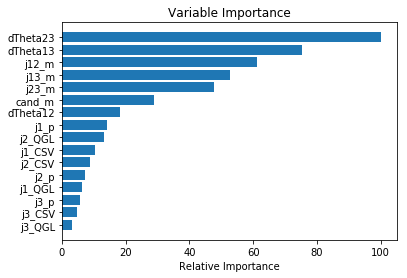

In [15]:
plt.rc('figure', figsize=(6, 4))
pos = np.arange(sorted_idx.shape[0]) + .5
_ = plt.barh(pos, feature_importance[sorted_idx], align='center')
_ = plt.yticks(pos, feature_names[sorted_idx])
_ = plt.xlabel('Relative Importance')
_ = plt.title('Variable Importance')

In [16]:
featureImportanceandNames = list(zip(feature_names, feature_importance))
print([featureImportanceandNames[a] for a in sorted_idx])

[('j3_QGL', 3.0761237332406952), ('j3_CSV', 4.716201128857147), ('j3_p', 5.6424345829498863), ('j1_QGL', 6.1777218209991789), ('j2_p', 7.2395801840350993), ('j2_CSV', 8.8172116092682238), ('j1_CSV', 10.301171716869433), ('j2_QGL', 13.249244281492158), ('j1_p', 14.044215435956007), ('dTheta12', 18.322598918129714), ('cand_m', 28.947311567678263), ('j23_m', 47.632264836127639), ('j13_m', 52.805529799308417), ('j12_m', 61.134669559481637), ('dTheta13', 75.354763033544302), ('dTheta23', 100.0)]


#### The predict correlation covariance matrix for the Random Forest training.

In [17]:
from scipy.linalg import fractional_matrix_power
def diagElements(m):
    size = m.shape[0]
    return np.matrix(np.diag([m[i, i] for i in range(size)]))

def corrMat(m):
    sqrt_diag = fractional_matrix_power(diagElements(m), -0.5)
    return np.array(sqrt_diag * m  * sqrt_diag)

def plot_corrMat(corrMat_input, varNames, figs, ax):
    sc=ax.matshow(corrMat_input, cmap=plt.cm.seismic, vmin=-1, vmax=1)
    _=ax.set_xticks(range(len(varNames)))
    _=ax.set_xticklabels(varNames, rotation='vertical')
    _=ax.set_yticks(range(len(varNames))) 
    _=ax.set_yticklabels(varNames)
    _=figs.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

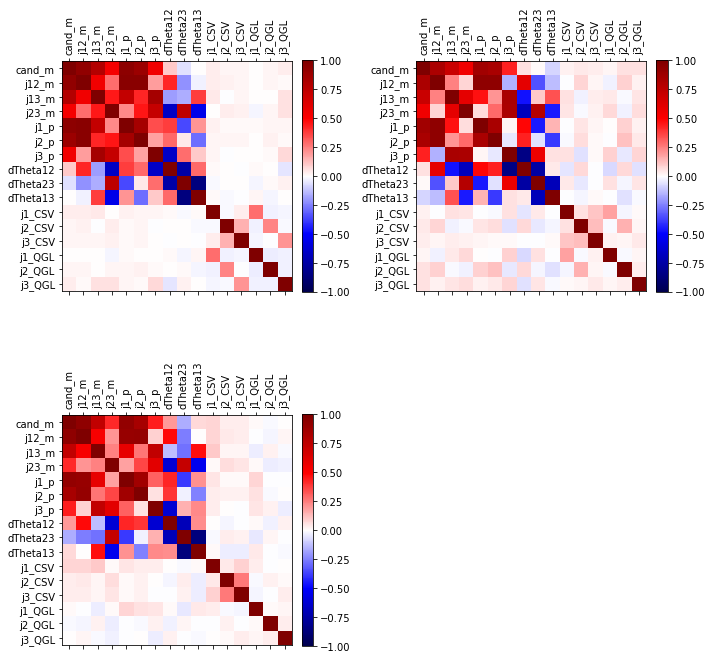

In [18]:
plt.rc('figure', figsize=(10, 10))
ecv = EmpiricalCovariance()
_=ecv.fit(val_slimNpData0_ttbar)
corr0_ttbar = corrMat(np.matrix(ecv.covariance_))
_=ecv.fit(val_slimNpData1_ttbar)
corr1_ttbar = corrMat(np.matrix(ecv.covariance_))
_=ecv.fit(val_slimNpData_zinv)
corr_zinv = corrMat(np.matrix(ecv.covariance_))
figs, axes = plt.subplots(2, 2)
plot_corrMat(corr0_ttbar, listToGet, figs, axes[0, 0])
plot_corrMat(corr1_ttbar, listToGet, figs, axes[0, 1])
plot_corrMat(corr_zinv, listToGet, figs, axes[1, 0])
figs.delaxes(axes[1, 1])
figs.tight_layout()
plt.show()

#### We have a base tagger used in the past. It's a simple tagger with squared cuts on some basic kinematic variables (loaded from the [baseTagger.py](baseTagger) file). Now we use it as a reference to find the improvement of the MVA training. Note that one of the feature the base tagger was it's high recall which is what we'd like to keep.

In [19]:
%time val_df['passBaseTagger'] = val_df.apply(baseTaggerReqs, axis=1)

CPU times: user 27.2 s, sys: 298 ms, total: 27.5 s
Wall time: 27.6 s


#### Some selections "sr_cuts" to ensure we have the events we are actually interested in. We then calculate various metrics for the base tagger.

In [20]:
sr_cuts = (val_df['Njet']>=4) & (val_df['MET']>200) & (val_df['cand_dRMax']<1.5)
baseTagger_fpr_tpr = val_df[sr_cuts].groupby(by=['answer', 'passBaseTagger'])['sampleWgt'].sum()
baseTagger_fpr_tpr
tp_base = baseTagger_fpr_tpr.loc[1, True]
fp_base = baseTagger_fpr_tpr.loc[0, True]
tn_base = baseTagger_fpr_tpr.loc[0, False]
fn_base = baseTagger_fpr_tpr.loc[1, False]
tpr_base = tp_base/(tp_base + fn_base)
fpr_base = fp_base/(fp_base + tn_base)

precision_base = tp_base/(tp_base + fp_base)
recall_base = tp_base/(tp_base + fn_base)

fscore_base = 2*precision_base*recall_base/(precision_base+recall_base)

fpr_base, tpr_base, precision_base, recall_base, fscore_base

answer  passBaseTagger
0       False              65868.476752
        True              128094.882087
1       False               3069.385830
        True               19059.424391
Name: sampleWgt, dtype: float64

(0.66040762984059254,
 0.86129458388375169,
 0.12951999059360264,
 0.86129458388375169,
 0.22517808937517617)

#### The roc plot and others for the trained results on the validation sample. For the Random Forest results, we scan the fpr and tpr to find a cut on the output probablity value where we get same recall as the base tagger but reduced fpr. 
#### From the ROC, we can see that the MLP result is better than the Random Forest. In my own configuration of the MLP (3 hidden layers) using tensorflow, I get slightly better result than the 2-hidden-layer MLP implemenation in scikit-learn for some regions. It seems the 2-hidden-layer MLP can already exploit much of the information with the feeded in high level variables. Deep neural network with lower level information (detector hits) could improve further.

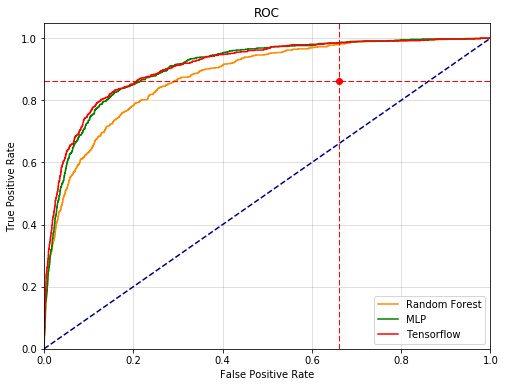

baseTagger tpr : 0.8612945838837517  fpr : 0.6604076298405925  fscore : 0.22517808937517617 --> precision : 0.12951999059360264  recall : 0.8612945838837517
mva (same_tpr) tpr : 0.8612945838837568  fpr : 0.29082973184176425  cut : 0.5583259088786727
mva (same_fpr) tpr : 0.9788639365918106  fpr : 0.6604770122954262  cut : 0.04932244798676676
mva (same_fscore) fscore : 0.2251929956693655  precision : 0.13131313131313133  recall : 0.7899603698811096  cut : 0.7466941714899687
mva (max_fscore) fscore : 0.44788164088769333  precision : 0.45616438356164385  recall : 0.43989431968295906  cut : 0.9808562737730054


In [21]:
plt.rc('figure', figsize=(8, 6))

val_npInputAnswers_sel = val_npInputAnswers[np.array(sr_cuts)]
val_output_sel = val_output[np.array(sr_cuts)]

precision, recall, thresholds_pr = precision_recall_curve(val_npInputAnswers_sel, val_output_sel)
fscore = 2*precision*recall/(precision + recall)
average_precision = average_precision_score(val_npInputAnswers_sel, val_output_sel)
fpr, tpr, thresholds_roc = roc_curve(val_npInputAnswers_sel, val_output_sel, sample_weight=np.array(val_df.loc[sr_cuts,'sampleWgt']))
roc_auc = auc(tpr, fpr)

val_mlp_output_sel = val_mlp_output[np.array(sr_cuts)]
fpr_mlp, tpr_mlp, thresholds_roc_mlp = roc_curve(val_npInputAnswers_sel, val_mlp_output_sel, sample_weight=np.array(val_df.loc[sr_cuts,'sampleWgt']))

val_tf_output_sel = val_tf_output[:, 1][np.array(sr_cuts)]
fpr_tf, tpr_tf, thresholds_roc_tf = roc_curve(val_npInputAnswers_sel, val_tf_output_sel, sample_weight=np.array(val_df.loc[sr_cuts,'sampleWgt']))

_ = plt.plot(fpr, tpr, color = 'darkorange', label = 'Random Forest')
_ = plt.plot(fpr_mlp, tpr_mlp, color = 'green', label = 'MLP')
_ = plt.plot(fpr_tf, tpr_tf, color = 'red', label = 'Tensorflow')
_ = plt.plot([0, 1], [0, 1], color='navy', linestyle = '--')
_ = plt.xlim([0.0, 1.0])
_ = plt.ylim([0.0, 1.05])
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC')
_ = plt.legend(loc='lower right')
_ = plt.plot(fpr_base, tpr_base, 'or')
_ = plt.plot([0, 1], [tpr_base, tpr_base], ls='--', color='red', lw=1)
_ = plt.plot([fpr_base, fpr_base], [0, 1.05], ls='--', color='red', lw=1)
_ = plt.grid(b=True, color='grey', ls='-', lw=0.5, alpha=0.5)
plt.show()
#_=plt.plot(recall, precision, color = 'darkorange')
#_=plt.xlim([0.0, 1.0])
#_=plt.ylim([0.0, 1.05])
#_=plt.xlabel('recall')
#_=plt.ylabel('precision')
#_=plt.title('precision-recall')
#_=plt.plot(precision_base, recall_base, 'or')
#plt.show()
# Get the cut value for where we have same tpr as the tpr_base
idx_same_tpr = -1
idx_same_fpr = -1
for i in range(len(fpr)-1):
    if(tpr[i]<tpr_base and tpr[i+1]>=tpr_base):
        idx_same_tpr = i+1
    if(fpr[i]<fpr_base and fpr[i+1]>=fpr_base):
        idx_same_fpr = i+1
idx_same_fscore = -1
idx_max_fscore = -1
for i in range(len(fscore)-1):
    if(fscore[i]<fscore_base and fscore[i+1]>=fscore_base):
        idx_same_fscore = i+1
    if idx_max_fscore == -1 or (fscore[idx_max_fscore]<fscore[i]):
        idx_max_fscore = i
# We want a high recall (tpr) working point (as high as the base tagger)
mva_cut = thresholds_roc[idx_same_tpr]
alt_mva_cut = thresholds_roc[idx_same_fpr]
print('baseTagger tpr : {}  fpr : {}  fscore : {} --> precision : {}  recall : {}'.format(tpr_base, fpr_base, fscore_base, precision_base, recall_base))
print('mva (same_tpr) tpr : {}  fpr : {}  cut : {}'.format(tpr[idx_same_tpr], fpr[idx_same_tpr], mva_cut))
print('mva (same_fpr) tpr : {}  fpr : {}  cut : {}'.format(tpr[idx_same_fpr], fpr[idx_same_fpr], alt_mva_cut))
print('mva (same_fscore) fscore : {}  precision : {}  recall : {}  cut : {}'.format(fscore[idx_same_fscore], precision[idx_same_fscore], recall[idx_same_fscore], thresholds_pr[idx_same_fscore]))
print('mva (max_fscore) fscore : {}  precision : {}  recall : {}  cut : {}'.format(fscore[idx_max_fscore], precision[idx_max_fscore], recall[idx_max_fscore], thresholds_pr[idx_max_fscore]))

#### The probability output distribution for signal and background (selected cut value is indicated)

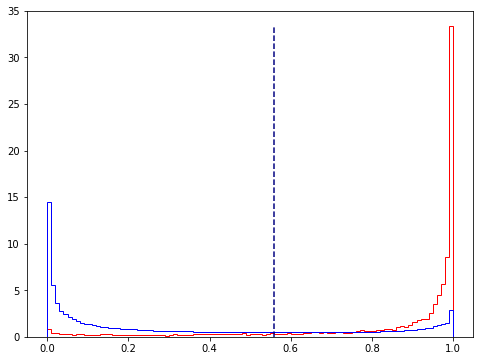

In [22]:
sig_val_output = val_output[val_npInputAnswers==1]
sig_val_wgt = val_npInputWgt[val_npInputAnswers==1]
bkg_val_output = val_output[val_npInputAnswers==0]
bkg_val_wgt = val_npInputWgt[val_npInputAnswers==0]
y_sig, x_sig, _=plt.hist(sig_val_output, range = (0, 1.0), weights=sig_val_wgt, normed = True, color = 'red', bins = 100, histtype='step')
y_bkg, x_bkg, _=plt.hist(bkg_val_output, range = (0, 1.0), weights=bkg_val_wgt, normed = True, color = 'blue', bins = 100, histtype='step')
_=plt.plot([mva_cut, mva_cut], [0, max(y_sig.max(), y_bkg.max())], color='navy', linestyle = '--')
plt.show()

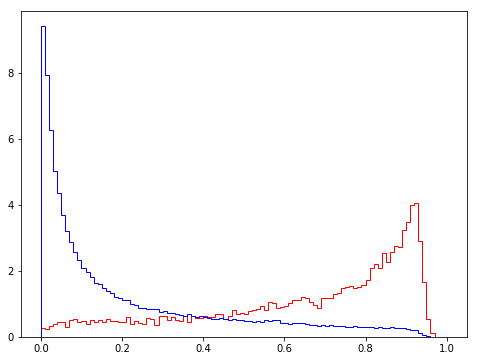

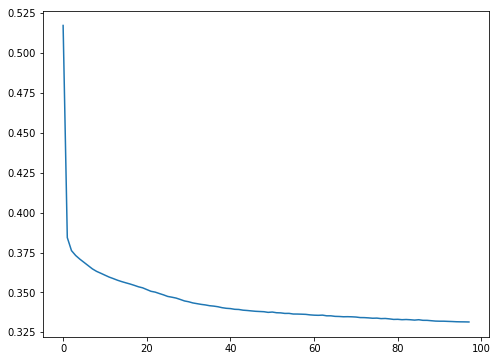

In [23]:
mlp_sig_val_output = val_mlp_output[val_npInputAnswers==1]
mlp_sig_val_wgt = val_npInputWgt[val_npInputAnswers==1]
mlp_bkg_val_output = val_mlp_output[val_npInputAnswers==0]
mlp_bkg_val_wgt = val_npInputWgt[val_npInputAnswers==0]
mlp_y_sig, mlp_x_sig, _=plt.hist(mlp_sig_val_output, weights=mlp_sig_val_wgt, range = (0, 1.0), normed = True, color = 'red', bins = 100, histtype='step')
mlp_y_bkg, mlp_x_bkg, _=plt.hist(mlp_bkg_val_output, weights=mlp_bkg_val_wgt, range = (0, 1.0), normed = True, color = 'blue', bins = 100, histtype='step')
plt.show()

_=plt.plot(clf_mlp.loss_curve_)

#### Finally we apply both base tagger and the MVA tagger on all the validation events. However additional treatment is done to resolve the overlap where multiple tagged candiates might share the same AK4 jet(s).

In [24]:
grouped_val_df = val_df.groupby(['evtNum', 'procTypes'])

In [25]:
%time sr_grouped_baseTagger = grouped_val_df.apply(resolveOverlapHEP)
df_grouped_baseTagger = sr_grouped_baseTagger.reset_index()
df_grouped_baseTagger =df_grouped_baseTagger.rename(columns={0:'baseTagger'})
val_df_baseTagger = pd.merge(val_df, df_grouped_baseTagger, how='outer', left_on = ['evtNum', 'procTypes'], 
         right_on = ['evtNum', 'procTypes'])
val_df_baseTagger.index = val_df.index
%time sr_grouped_mvaTagger = grouped_val_df.apply(resolveOverlap, mva_cut)
df_grouped_mvaTagger = sr_grouped_mvaTagger.reset_index()
df_grouped_mvaTagger = df_grouped_mvaTagger.rename(columns={0:'mvaTagger'})
val_df_taggers = pd.merge(val_df_baseTagger, df_grouped_mvaTagger, 
                                          how='outer', left_on=['evtNum', 'procTypes'],
                                         right_on=['evtNum', 'procTypes'])
val_df_taggers.index = val_df.index

CPU times: user 1min 29s, sys: 276 ms, total: 1min 29s
Wall time: 1min 30s
CPU times: user 1min 28s, sys: 316 ms, total: 1min 29s
Wall time: 1min 29s


#### An example display of the final DataFrame with the taggers

In [26]:
val_df_taggers.head()

,cand_m,j12_m,j13_m,j23_m,j1_p,j2_p,j3_p,dTheta12,dTheta23,dTheta13,...,procTypes,evtNum,MET,Njet,Bjet,sampleWgt,disc,passBaseTagger,baseTagger,mvaTagger
0,170.889643,117.132308,89.360911,90.255910,60.768501,59.667680,45.119558,2.373794,1.932072,1.977319,...,ttbar,1,41.443445,5,1,29.232246,0.995877,True,[<baseTagger.simpleTopCandHEP object at 0x125c...,[<baseTagger.simpleTopCand object at 0x10c8914...
1,207.881769,166.500611,113.792454,58.568288,93.711212,72.059351,37.017274,2.774157,1.141826,2.367203,...,ttbar,1,41.443445,5,1,29.232246,0.010447,True,[<baseTagger.simpleTopCandHEP object at 0x125c...,[<baseTagger.simpleTopCand object at 0x10c8914...
2,168.919911,121.223590,104.941329,54.473935,75.551056,51.357779,40.668776,2.610579,1.224871,2.447735,...,ttbar,2,55.017690,9,2,29.232246,0.204912,False,[<baseTagger.simpleTopCandHEP object at 0x119e...,[<baseTagger.simpleTopCand object at 0x10c8916...
3,178.553501,135.950812,102.983519,54.473935,80.739760,59.156055,37.185479,2.699864,1.189609,2.393711,...,ttbar,2,55.017690,9,2,29.232246,0.106812,True,[<baseTagger.simpleTopCandHEP object at 0x119e...,[<baseTagger.simpleTopCand object at 0x10c8916...
4,203.124755,147.022776,125.301280,65.782914,90.681535,61.717518,47.625345,2.630705,1.197125,2.455355,...,ttbar,2,55.017690,9,2,29.232246,0.011198,False,[<baseTagger.simpleTopCandHEP object at 0x119e...,[<baseTagger.simpleTopCand object at 0x10c8916...


In [27]:
!jupyter nbconvert --to python top_tagger.ipynb

[NbConvertApp] Converting notebook top_tagger.ipynb to python
[NbConvertApp] Writing 24865 bytes to top_tagger.py
